# COGS 108 - EDA Checkpoint



# Names

- Andrew Hernandez
- Austin Nguyen
- Christian Kim
- Kevin De Silva Jayasinghe

<a id='research_question'></a>
# Research Question

*Does an increase in tweets with the hashtag description '#bitcoin' correlate with an increase in bitcoin price? What time frame relationship holds the strongest correlation?*
- Does the number of tweets about bitcoin in one week correlate with the change in price of bitcoin the next week?
- Is there a relationship between the number of tweets on a given day, and the change in price of bitcoin the day after?

# Setup

In [1]:
import pandas as pd
import numpy as np
import requests 
from bs4 import BeautifulSoup
import re
import patsy
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# Get daily bitcoin price from 01/01/2019 - 12/31/2019
btc_2019_daily = pd.read_csv('btc_2019.csv')

# Get daily bitcoin price from 01/01/2020 - 12/31/2020
btc_2020_daily = pd.read_csv('btc_2020.csv')

# Concatenate both years' data together into one dataframe
btc_2019_2020_daily = pd.concat([btc_2020_daily, btc_2019_daily])

# Remove commas of the open, high, low, and close to cast into int
btc_2019_2020_daily = btc_2019_2020_daily.replace(',', '', regex=True)

# Cast the open, high, low, and close into ints so we can perform calculations on these values
btc_2019_2020_daily = btc_2019_2020_daily.astype({'Open': 'int32', 'High': 'int32', 'Low': 'int32', 'Close': 'int32'})

# Create a new column called PriceChange which will be the difference between the close and open price.
# We will use this to tell how much the price changed (will be used in measuring the correlation)
btc_2019_2020_daily = btc_2019_2020_daily.assign(PriceChange = (btc_2019_2020_daily['Close'] - btc_2019_2020_daily['Open']))

# Create a new column which converts the Date into DateTime so it is easier to work with and graph
btc_2019_2020_daily['DateTime'] = pd.to_datetime(btc_2019_2020_daily['Date'])

# Create a new column which converts the Date into DateTime and subtract 6 days so we can group the daily prices into weekly prices
# We will use this to group the data into weeks for the second part of the research question
btc_2019_2020_daily['DateTimeGroup'] = pd.to_datetime(btc_2019_2020_daily['Date']) - pd.to_timedelta(6, unit='d')

# Create two dataframes where the first gets the opening price of the week and the second gets the closing price of the week.
# The keys will be the same so we can merge them to create a single table
btc_2019_2020_weekly_open = btc_2019_2020_daily.groupby(pd.Grouper(key='DateTimeGroup', freq='W-TUE'))[['Open']].first().reset_index().sort_values('DateTimeGroup')
btc_2019_2020_weekly_close = btc_2019_2020_daily.groupby(pd.Grouper(key='DateTimeGroup', freq='W-TUE'))[['Close']].last().reset_index().sort_values('DateTimeGroup')

# Merge the two previous btc_2019_2020_weekly_open and btc_2019_2020_weekly_close tables.
# This weekly form of the dataset has the key of the first day of the week (where we know the end date is the day before the next key)
btc_2019_2020_weekly = pd.merge(btc_2019_2020_weekly_open, btc_2019_2020_weekly_close, on=['DateTimeGroup'])
btc_2019_2020_weekly = btc_2019_2020_weekly.assign(PriceChange = (btc_2019_2020_weekly['Close'] - btc_2019_2020_weekly['Open']))

print(btc_2019_2020_weekly)
btc_2019_2020_daily
# The datasets were split up by year so we had to concatenate
# The data was already mostly clean so we only had to typecast the strings into integers and remove commas
# We then added a column which contains PriceChange which is what we will use to determine
# if the increase in tweets with the hashtag description '#bitcoin' correlates with an increase in bitcoin price
# We also added a column for datetime to make it easy to work with and to create a dataframe where we group it by weekly prices


    DateTimeGroup   Open  Close  PriceChange
0      2019-01-01   3722   4040          318
1      2019-01-08   4041   3693         -348
2      2019-01-15   3693   3537         -156
3      2019-01-22   3537   3442          -95
4      2019-01-29   3442   3445            3
..            ...    ...    ...          ...
100    2020-12-01  19380  19087         -293
101    2020-12-08  19087  19201          114
102    2020-12-15  19199  23146         3947
103    2020-12-22  23138  26634         3496
104    2020-12-29  26606  28966         2360

[105 rows x 4 columns]


,Date,Open,High,Low,Close,PriceChange,DateTime,DateTimeGroup
0,12/31/2020,28898,29298,27989,28966,68,2020-12-31,2020-12-25
1,12/30/2020,26870,28980,26870,28896,2026,2020-12-30,2020-12-24
2,12/29/2020,26606,27164,25926,26870,264,2020-12-29,2020-12-23
3,12/28/2020,26303,27404,26136,26634,331,2020-12-28,2020-12-22
4,12/27/2020,26666,28326,25824,26303,-363,2020-12-27,2020-12-21
...,...,...,...,...,...,...,...,...
360,01/05/2019,3878,3912,3859,3880,2,2019-01-05,2018-12-30
361,01/04/2019,3840,3895,3774,3878,38,2019-01-04,2018-12-29
362,01/03/2019,3937,3964,3813,3841,-96,2019-01-03,2018-12-28
363,01/02/2019,3767,3943,3757,3931,164,2019-01-02,2018-12-27


In [3]:
# We found this web scraping script at https://stackoverflow.com/questions/47730259/installing-urllib-in-python3-6 
# and made some minor modifications in order to fit to our needs in terms of retrieving the amount of tweets on a daily basis.
# We have to further clean the data by extracting all days between 01/01/2019 - 12/31/2020 and then 
# grouping the data into a weekly format (sum amount of tweets for all days in a given week) 
# in order answer the second part of our question

# Function to clean the string
def parse_strlist(sl):
    # Remove the uncessary commans and brackets
    clean = re.sub("[\[\],\s]","",sl)
    # Split the remaining text by " to a list where a date is followed by the number of tweets
    splitted = re.split("[\'\"]",clean)
    # Filter out empty segments of the array since the " occurs at the beginning leading to an empty string in the list
    values_only = [s for s in splitted if s != '']
    return values_only

# Make a request to the website with the dataset and parse its html
url = 'https://bitinfocharts.com/comparison/tweets-btc.html#3y'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Since the data is stored in the script tags we will search in there
scripts = soup.find_all('script', text=True)
for script in scripts:
    # The script tag we are looking for contains this content inside so we will parse it if we find this string inside
    if 'd = new Dygraph(document.getElementById("container")' in str(script):
        # Since there are various things inside the script tag, we will search for the array holding the date specifically
        StrList = str(script)
        StrList = '[[' + StrList.split('[[')[-1]
        StrList = StrList.split(']]')[0] +']]'
        # We will replace the js date parser surrounding the date we want
        StrList = StrList.replace("new Date(", '').replace(')','')
        # Parse the string into an list so we can create the dataframe
        dataList = parse_strlist(StrList)

        # Make a dataframe from the parsed data
        date = []
        tweet = []
        for each in dataList:
            if (dataList.index(each) % 2) == 0:
                date.append(each)
            else:
                tweet.append(each)
        tweets_daily = pd.DataFrame(list(zip(date, tweet)), columns=["Date", "Tweets"])

# This dataframe has one null value so we will need to remove it
tweets_daily = tweets_daily[tweets_daily["Tweets"] != "null"]

# Cast the tweet count into ints so we can perform calculations on these values
tweets_daily = tweets_daily.astype({"Tweets": "int64"})

tweets_daily

,Date,Tweets
0,2014/04/09,8193
1,2014/04/10,15039
2,2014/04/11,14907
3,2014/04/12,7582
4,2014/04/13,10674
...,...,...
2596,2021/05/18,120021
2597,2021/05/19,363566
2598,2021/05/20,173415
2599,2021/05/21,185009


In [4]:
# Filter our tweet dataframe so that we only include the tweet counts from the years 2019 and 2020
tweets_2019_2020_daily = tweets_daily[(tweets_daily.Date.str.contains("2019", na=False)) | (tweets_daily.Date.str.contains("2020", na=False))]

# Create a new column which converts the Date into DateTime so it is easier to work with and graph
tweets_2019_2020_daily['DateTime'] = pd.to_datetime(tweets_2019_2020_daily['Date'])

# Create a new column which converts the Date into DateTime and subtract 6 days so we can group the daily tweet count into tweet count prices
# We will use this to group the data into weeks for the second part of the research question
tweets_2019_2020_daily['DateTimeGroup'] = pd.to_datetime(tweets_2019_2020_daily['Date']) - pd.to_timedelta(6, unit='d')

# Group the number of tweets by week
tweets_2019_2020_weekly = tweets_2019_2020_daily.groupby(pd.Grouper(key='DateTimeGroup', freq='W-TUE'))[['Tweets']].sum().reset_index().sort_values('DateTimeGroup')

print(tweets_2019_2020_daily)
tweets_2019_2020_weekly

            Date  Tweets   DateTime DateTimeGroup
1728  2019/01/01   17069 2019-01-01    2018-12-26
1729  2019/01/02   18830 2019-01-02    2018-12-27
1730  2019/01/03   26754 2019-01-03    2018-12-28
1731  2019/01/04   21139 2019-01-04    2018-12-29
1732  2019/01/05   20096 2019-01-05    2018-12-30
...          ...     ...        ...           ...
2454  2020/12/27   88788 2020-12-27    2020-12-21
2455  2020/12/28   59779 2020-12-28    2020-12-22
2456  2020/12/29   56236 2020-12-29    2020-12-23
2457  2020/12/30   80886 2020-12-30    2020-12-24
2458  2020/12/31   68822 2020-12-31    2020-12-25

[730 rows x 4 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,DateTimeGroup,Tweets
0,2019-01-01,143247
1,2019-01-08,132086
2,2019-01-15,130601
3,2019-01-22,125986
4,2019-01-29,123895
...,...,...
100,2020-12-01,323904
101,2020-12-08,278768
102,2020-12-15,539526
103,2020-12-22,402965


In [5]:
# Manually create a dataframe with monthly twitter users from "Twitter Monthly Active"
twitter_monthly_users_data = { 'Quarter': ['Q1', 'Q2', 'Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4'],
         'Year': [2019,2019,2019,2019,2020,2020,2020,2020],
         'MUA':  [330000000,330000000,330000000,340000000,326000000,326000000,353000000,np.nan]}

twitter_monthly_users = pd.DataFrame(twitter_monthly_users_data)
twitter_monthly_users

,Quarter,Year,MUA
0,Q1,2019,330000000.0
1,Q2,2019,330000000.0
2,Q3,2019,330000000.0
3,Q4,2019,340000000.0
4,Q1,2020,326000000.0
5,Q2,2020,326000000.0
6,Q3,2020,353000000.0
7,Q4,2020,NaN


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

We merged the weekly tweet and bitcoin dataframes together to put all data into one graph since both data deal with the same time frame.


In [6]:
btc_tweets_2019_2020_weekly = pd.merge(btc_2019_2020_weekly, tweets_2019_2020_weekly, how="left", on=['DateTimeGroup'])
btc_tweets_2019_2020_weekly

,DateTimeGroup,Open,Close,PriceChange,Tweets
0,2019-01-01,3722,4040,318,143247
1,2019-01-08,4041,3693,-348,132086
2,2019-01-15,3693,3537,-156,130601
3,2019-01-22,3537,3442,-95,125986
4,2019-01-29,3442,3445,3,123895
...,...,...,...,...,...
100,2020-12-01,19380,19087,-293,323904
101,2020-12-08,19087,19201,114,278768
102,2020-12-15,19199,23146,3947,539526
103,2020-12-22,23138,26634,3496,402965


We merged the daily tweet and bitcoin dataframes together to put all data into one graph since both data deal with the same time frame.

In [7]:
btc_tweets_2019_2020_daily = pd.merge(btc_2019_2020_daily, tweets_2019_2020_daily, how="left", on=['DateTime'])
btc_tweets_2019_2020_daily

,Date_x,Open,High,Low,Close,PriceChange,DateTime,DateTimeGroup_x,Date_y,Tweets,DateTimeGroup_y
0,12/31/2020,28898,29298,27989,28966,68,2020-12-31,2020-12-25,2020/12/31,68822.0,2020-12-25
1,12/30/2020,26870,28980,26870,28896,2026,2020-12-30,2020-12-24,2020/12/30,80886.0,2020-12-24
2,12/29/2020,26606,27164,25926,26870,264,2020-12-29,2020-12-23,2020/12/29,56236.0,2020-12-23
3,12/28/2020,26303,27404,26136,26634,331,2020-12-28,2020-12-22,2020/12/28,59779.0,2020-12-22
4,12/27/2020,26666,28326,25824,26303,-363,2020-12-27,2020-12-21,2020/12/27,88788.0,2020-12-21
...,...,...,...,...,...,...,...,...,...,...,...
726,01/05/2019,3878,3912,3859,3880,2,2019-01-05,2018-12-30,2019/01/05,20096.0,2018-12-30
727,01/04/2019,3840,3895,3774,3878,38,2019-01-04,2018-12-29,2019/01/04,21139.0,2018-12-29
728,01/03/2019,3937,3964,3813,3841,-96,2019-01-03,2018-12-28,2019/01/03,26754.0,2018-12-28
729,01/02/2019,3767,3943,3757,3931,164,2019-01-02,2018-12-27,2019/01/02,18830.0,2018-12-27


Shift the daily tweet prices up to the next day to create the stagger.

In [8]:
btc_tweets_2019_2020_daily_staggered = btc_tweets_2019_2020_daily
btc_tweets_2019_2020_daily_staggered['Tweets'] = btc_tweets_2019_2020_daily_staggered['Tweets'].shift(-1)
btc_tweets_2019_2020_daily_staggered

,Date_x,Open,High,Low,Close,PriceChange,DateTime,DateTimeGroup_x,Date_y,Tweets,DateTimeGroup_y
0,12/31/2020,28898,29298,27989,28966,68,2020-12-31,2020-12-25,2020/12/31,80886.0,2020-12-25
1,12/30/2020,26870,28980,26870,28896,2026,2020-12-30,2020-12-24,2020/12/30,56236.0,2020-12-24
2,12/29/2020,26606,27164,25926,26870,264,2020-12-29,2020-12-23,2020/12/29,59779.0,2020-12-23
3,12/28/2020,26303,27404,26136,26634,331,2020-12-28,2020-12-22,2020/12/28,88788.0,2020-12-22
4,12/27/2020,26666,28326,25824,26303,-363,2020-12-27,2020-12-21,2020/12/27,72172.0,2020-12-21
...,...,...,...,...,...,...,...,...,...,...,...
726,01/05/2019,3878,3912,3859,3880,2,2019-01-05,2018-12-30,2019/01/05,21139.0,2018-12-30
727,01/04/2019,3840,3895,3774,3878,38,2019-01-04,2018-12-29,2019/01/04,26754.0,2018-12-29
728,01/03/2019,3937,3964,3813,3841,-96,2019-01-03,2018-12-28,2019/01/03,18830.0,2018-12-28
729,01/02/2019,3767,3943,3757,3931,164,2019-01-02,2018-12-27,2019/01/02,17069.0,2018-12-27


Shift the weekly tweet prices up to the next day to create the stagger.

In [9]:
btc_tweets_2019_2020_weekly_staggered = btc_tweets_2019_2020_weekly
# Reorient the dataframe so it is the same direction as daily
btc_tweets_2019_2020_weekly_staggered = btc_tweets_2019_2020_weekly_staggered.iloc[::-1]
btc_tweets_2019_2020_weekly_staggered['Tweets'] = btc_tweets_2019_2020_weekly_staggered['Tweets'].shift(-1)
btc_tweets_2019_2020_weekly_staggered

,DateTimeGroup,Open,Close,PriceChange,Tweets
104,2020-12-29,26606,28966,2360,402965.0
103,2020-12-22,23138,26634,3496,539526.0
102,2020-12-15,19199,23146,3947,278768.0
101,2020-12-08,19087,19201,114,323904.0
100,2020-12-01,19380,19087,-293,359769.0
...,...,...,...,...,...
4,2019-01-29,3442,3445,3,125986.0
3,2019-01-22,3537,3442,-95,130601.0
2,2019-01-15,3693,3537,-156,132086.0
1,2019-01-08,4041,3693,-348,143247.0


First we will look at the weekly bitcoin price change statistics.

In [10]:
btc_tweets_2019_2020_weekly['PriceChange'].describe()

count     105.000000
mean      240.628571
std       956.161560
min     -2956.000000
25%      -225.000000
50%       101.000000
75%       569.000000
max      3947.000000
Name: PriceChange, dtype: float64

As we can see 50% of the weekly price changes fall within -225 USD and 569 USD centering around the mean at 101 USD. In addition we can see that there are some outlier values in both directions. In the positive direction we have 3947 USD which is more than ((569 - (-225)) * 1.5 + 569 USD) = 1760 USD. In the negative direction we have -2956 USD which is less than -224 + -((569 - (-225)) * 1.5) = -1415 USD. We will generate a histogram to more easily visualize this data.

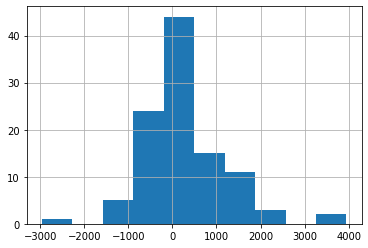

In [11]:
btc_tweets_2019_2020_weekly['PriceChange'].hist()

In addition to the data from the table, we can see that the price changes approximately form a normal distribution curve and that there are several outliers (especially in the positive direction).

Now we will look at the statistics of the weekly tweets. Based on these statistics it seems that most of the data is closer to the mean (based on the first and second quartile as well as the median) with a tail to the right.

In [12]:
btc_tweets_2019_2020_weekly['Tweets'].describe()

count       105.000000
mean     186097.752381
std       76974.549436
min      104876.000000
25%      126393.000000
50%      171519.000000
75%      222160.000000
max      539526.000000
Name: Tweets, dtype: float64

We will generate a histogram to more easily visualize this data. As we can see the data is right skewed with several outliers (as several data points are greater than (222160 - 126393) * 1.5 + 222160 = 365810.5 tweets).

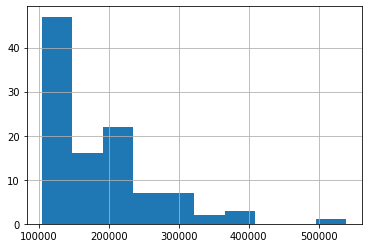

In [13]:
btc_tweets_2019_2020_weekly['Tweets'].hist()

[link text](https:// [link text](https://)) Below we created a time series chart to showcase the change in number of tweets and the price of Bitcoin over the January 2019 to December 2020 time frame. While we have been looking the weekly distribution before, we will now work with the staggered weekly data since we want to look at the week after for our analysis

 We can see there seems to be a correlation between the two sets of data. From 01/2019 - 01/2020 they both have small fluctuations then we see what seems to be an inversse relationship from  about 02/2020 - 10/2020. Finally around 12/2020 we see a strong reltionship between the two where it seems as if a large increase in tweets is followed by a large price increase then a large decrease in tweets leads to a large decrease in price. Overall, the graph below visually suggests there may be a relationship betweeb price change and tweets. 

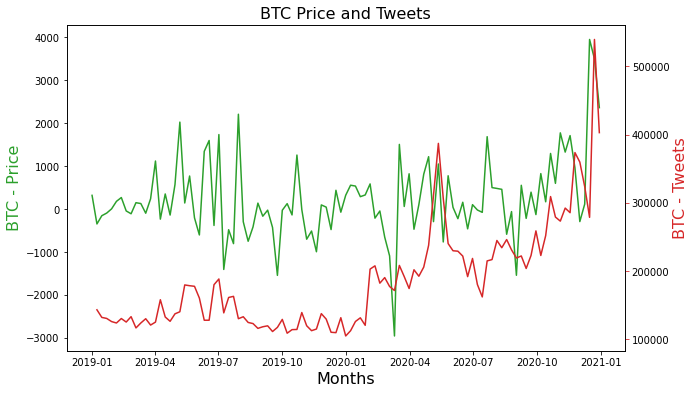

In [14]:
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
ax1.set_title('BTC Price and Tweets', fontsize=16)
ax1.set_xlabel('Months', fontsize=16)
ax1.set_ylabel('BTC - Price', fontsize=16, color=color)
ax2 = sns.lineplot(x ='DateTimeGroup', y ='PriceChange', data=btc_tweets_2019_2020_weekly_staggered, color=color)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('BTC - Tweets', fontsize=16, color=color)
ax2 = sns.lineplot(x ='DateTimeGroup', y ='Tweets', data=btc_tweets_2019_2020_weekly_staggered, color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

Execute a linear regression to find the effect of the weekly number of tweets on the next weeks' weekly price change of bitcoin

In [15]:
outcome, predictors = patsy.dmatrices('PriceChange ~ Tweets', btc_tweets_2019_2020_weekly_staggered)
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            PriceChange   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     19.68
Date:                Sat, 22 May 2021   Prob (F-statistic):           2.31e-05
Time:                        04:41:10   Log-Likelihood:                -852.13
No. Observations:                 104   AIC:                             1708.
Df Residuals:                     102   BIC:                             1714.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -689.1985    226.635     -3.041      0.0

Based on the linear regression, we see that there is a correlation between tweets the the price change of bitcoin (as there is a p-value of 0.000). The linear regression suggest if there are no tweets on bitcoin, the value of the coin would drop 689.1985 USD the following week. Each tweet in the corresponding week would increase the value of the coin by 0.005 USD the next week. This suggest that there is a correlation between the number of tweets on a given week and bitcoin price the following week.

Here we visualize the linear regression. As we saw in the data, there is a positive correlation between tweets in a given and an increase in bitcoin price change in the following week

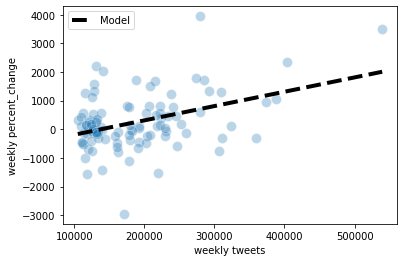

In [16]:
sns.scatterplot(x='Tweets', y='PriceChange', data=btc_tweets_2019_2020_weekly_staggered, alpha=0.3, s=100)

# Generate and plot the model fit line
xs = np.arange(btc_tweets_2019_2020_weekly_staggered['Tweets'].min(), btc_tweets_2019_2020_weekly_staggered['Tweets'].max())
ys = 0.0050 * xs -689.1985
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('weekly tweets')
plt.ylabel('weekly percent_change')
plt.legend()

We will now repeat the previous steps for the daily range

As we can see the statistics of the daily price change follows approximately the distribution of the weekly price change although on a smaller scale. As we can see, once again we have outliers.

In [17]:
btc_tweets_2019_2020_daily['PriceChange'].describe()

count     731.000000
mean       33.876881
std       352.529981
min     -2100.000000
25%      -103.000000
50%        14.000000
75%       156.000000
max      2239.000000
Name: PriceChange, dtype: float64

We generate a histogram to more easily visualize the data. As we can see there are some outliers on both ends.

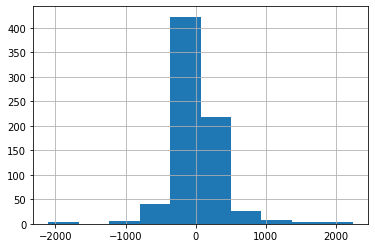

In [18]:
btc_tweets_2019_2020_daily['PriceChange'].hist()

Next we will look at the daily bitcoin tweet statistics

In [19]:
btc_tweets_2019_2020_daily['Tweets'].describe()

count       729.000000
mean      26709.796982
std       12871.112058
min       13294.000000
25%       17972.000000
50%       22847.000000
75%       31927.000000
max      127155.000000
Name: Tweets, dtype: float64

As we can see the statistics of the daily tweets follows approximately the distribution of the weekly tweet although on a smaller scale. As we can see, once again we have strong right skew which we can more easily see with the generated histogram. As we can see once again there are several outliers in the positive direction.

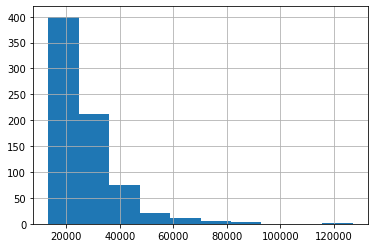

In [55]:
btc_tweets_2019_2020_daily['Tweets'].hist()

Below we created a time series chart to showcase the change in number of tweets and the price of Bitcoin over the January 2019 to December 2020 time frame using the staggered daily information.

We can see there seems to be a correlation between the two sets of data. At the high spikes of tweets relating to bitcoin we also see high spikes in following day price change of bitcoin and visa versa. While this relationship is not strong during 01/2019 - 01/2020. In the last few months of 2020 the correlation seems quite strong.

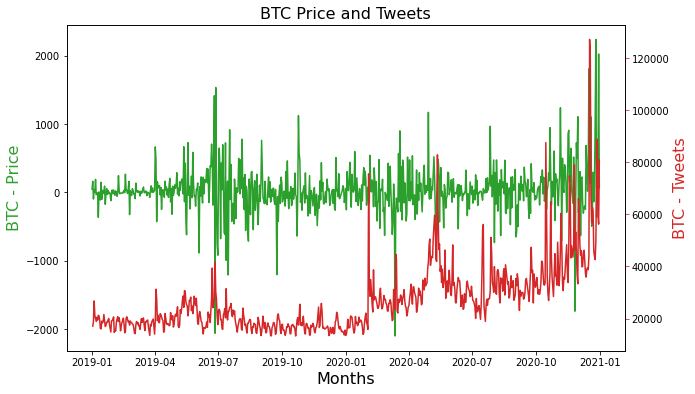

In [20]:
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:green'
ax1.set_title('BTC Price and Tweets', fontsize=16)
ax1.set_xlabel('Months', fontsize=16)
ax1.set_ylabel('BTC - Price', fontsize=16, color=color)
ax2 = sns.lineplot(x ='DateTime', y ='PriceChange', data=btc_tweets_2019_2020_daily_staggered, color=color)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('BTC - Tweets', fontsize=16, color=color)
ax2 = sns.lineplot(x ='DateTime', y ='Tweets', data=btc_tweets_2019_2020_daily_staggered, color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

We will confirm that there is a relationship using linear regression

In [78]:
outcome, predictors = patsy.dmatrices('PriceChange ~ Tweets', btc_tweets_2019_2020_daily_staggered)
mod = sm.OLS(outcome, predictors)
res = mod.fit() 
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            PriceChange   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     14.04
Date:                Sat, 22 May 2021   Prob (F-statistic):           0.000193
Time:                        04:24:30   Log-Likelihood:                -5303.6
No. Observations:                 729   AIC:                         1.061e+04
Df Residuals:                     727   BIC:                         1.062e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -66.9144     29.868     -2.240      0.0

Based on the linear regression, we see that there is a correlation between tweets the the price change of bitcoin (as there is a p-value of 0.000). The linear regression suggest if there are no tweets on bitcoin, the value of the coin would drop 66.9144 USD the following day. Each tweet in the corresponding day would increase the value of the coin by 0.005 USD the next day. This suggest that there is a correlation between the number of tweets on a given day and bitcoin price the following day. Below we visualize this correlation with a chart

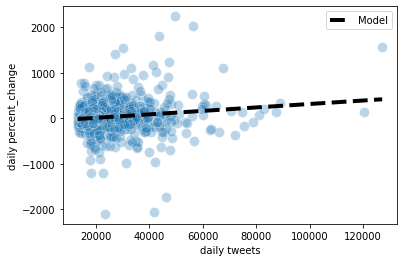

In [79]:
sns.scatterplot(x='Tweets', y='PriceChange', data=btc_tweets_2019_2020_daily, alpha=0.3, s=100)

# Generate and plot the model fit line
xs = np.arange(btc_tweets_2019_2020_daily['Tweets'].min(), btc_tweets_2019_2020_daily['Tweets'].max())
ys = 0.0038 * xs -66.9144
plt.plot(xs, ys, '--k', linewidth=4, label='Model')

plt.xlabel('daily tweets')
plt.ylabel('daily percent_change')
plt.legend()